# Generating CEO labeling project
**Author**: Hannah Kerner (hkerner@umd.edu) and Ivan Zvonkov (izvonkov@umd.edu)

**Description**: This notebook contains:
1. Code to select a region of interest from a shapefile
2. Code for creating a shapefile with points randomly sampled inside a the region of interest
3. Instructions for creating a CEO (Collect Earth Online) project using the random sample shapefile.

In [1]:
from shapely.geometry import Point
from pathlib import Path
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import numpy as np
import random
import matplotlib.pyplot as plt
import shutil

random.seed(0)

## 1. Selecting the region(s) of interest
The priority list for regions of interest can be found here: https://docs.google.com/spreadsheets/d/1y94ZV2z2biW8IX6SoPDNJ4PFXK_27_rxsOqY_jlbzhc/edit?usp=sharing

In [3]:
################################################################################
# THIS IS THE ONLY CELL THAT SHOULD BE EDITED WHEN RUNNING THIS NOTEBOOK
################################################################################
sample_amount = 1200
project_name = "Malawi_2022"
country_code = "MWI" # Can be found https://www.iso.org/obp/ui/#search under the Alpha-3 code column
regions_of_interest = [ ]

# Alternatively instead of the regions_of_interest variable, you can use a shapefilead of specifying the above country code and regions a custom shapefile path can be provided
custom_shapefile = ""

# After running the below cells it turns out that Zambezi region is not found in the shapefile, 
# instead we find Caprivi in its place. 
# For some wild history see: https://www.ati-holidays.com/history-of-the-caprivi/
# We therefore make the substition in our region of interest list
#   regions_of_interest[-1] = "Caprivi"

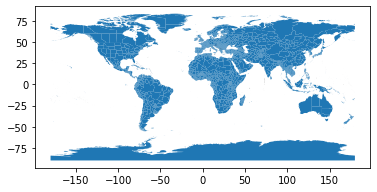

In [4]:
if not custom_shapefile: 
    # Load in shapefile from natural earth
    ne_shapefile = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
    ne_gdf = gpd.read_file(ne_shapefile)
    ne_gdf.plot();

Entire country found!


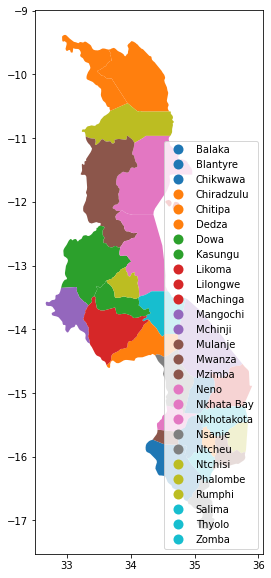

In [5]:
if custom_shapefile:
    boundary = gpd.read_file(custom_shapefile)
    boundary.plot();
else:
    # Load in shapefile from natural earth
    ne_shapefile = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
    ne_gdf = gpd.read_file(ne_shapefile)
    
    if len(regions_of_interest) == 0:
        # Select entire country (all regions):
        condition = ne_gdf["adm1_code"].str.startswith(country_code)
        boundary = ne_gdf[condition].copy()
        print("Entire country found!")
        
    else:
        # Check regions
        available_regions = ne_gdf[ne_gdf["adm1_code"].str.startswith(country_code)]["name"].tolist()
        regions_not_found = [region for region in regions_of_interest if region not in available_regions]

        if len(regions_not_found) > 0:
            condition = ne_gdf["adm1_code"].str.startswith(country_code)
            boundary = None
            print(f"WARNING: {regions_not_found} was not found. Please select regions only seen in below plot.")
        else:
            condition = ne_gdf["name"].isin(regions_of_interest)
            boundary = ne_gdf[condition].copy()
            print("All regions found!")
    
    ne_gdf[condition].plot(
        column="name", 
        legend=True, 
        legend_kwds={'loc': 'lower right'}, 
        figsize=(10,10)
    );

In [6]:
# Verify boundary is set
assert boundary is not None, "Boundary was not set in above cell, most likely due to not all regions found."

# Make sure the shapefile has EPSG:4326, otherwise convert it
print('Boundary shapefile CRS is %s' % boundary.crs)
if boundary.crs == None:
    boundary = boundary.set_crs('epsg:4326')
    print('Boundary shapefile set to %s' % boundary.crs)
if boundary.crs != 'epsg:4326':
    boundary = boundary.to_crs('epsg:4326')
    print('Boundary shapefile converted to %s' % boundary.crs)

Boundary shapefile CRS is None
Boundary shapefile set to epsg:4326


## 2. Creating shapefile with points in each region
In order to evaluate crop land mapping methodologies a random sample can be used to obtain an estimate of overall map user accuracy and producer accuracy.

In [7]:
def create_shapefile_zip(gdf, filename):
    p = Path(f"../data/shapefiles") / filename
    gdf.to_file(p, index=False)
    shutil.make_archive(p, 'zip', p)
    shutil.rmtree(p)

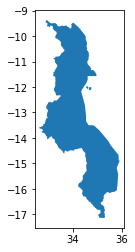

In [8]:
boundary["roi"] = True
dissolved_boundary = boundary.dissolve(by="roi")
dissolved_boundary.plot()
create_shapefile_zip(dissolved_boundary, f"{project_name}_boundary")

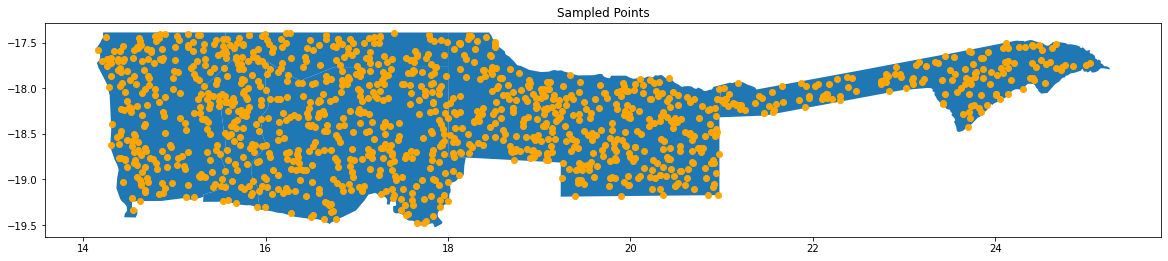

In [11]:
# Function for sampling random points. 
# From https://gis.stackexchange.com/questions/294394/randomly-sample-from-geopandas-dataframe-in-python
def random_points_in_polygon(num_points, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < num_points:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points  # returns list of shapely points

# Sample n points within the shapefile
points = random_points_in_polygon(sample_amount, dissolved_boundary.iloc[0].geometry)
    
# Convert the list of points to a geodataframe
points_gdf = gpd.GeoDataFrame([], geometry=gpd.points_from_xy(x=[p.x for p in points], 
                                                                  y=[p.y for p in points]))

# Plot the random points
fig, ax = plt.subplots(1, figsize=(20,20))
ax.set_title("Sampled Points")
boundary.plot(ax=ax)
points_gdf.plot(ax=ax, color="orange");

In [12]:
# Add columns for CEO formatting
points_gdf['PLOTID'] = points_gdf.index
points_gdf['SAMPLEID'] = points_gdf.index

# Set the data type of the IDs to be integers
points_gdf['SAMPLEID'] = points_gdf['SAMPLEID'].astype(np.int64)
points_gdf['PLOTID'] = points_gdf['PLOTID'].astype(np.int64)

# Set crs
points_gdf.crs = 'epsg:4326'

In [13]:
# Save the file as a new shapefile
create_shapefile_zip(points_gdf[['geometry', 'PLOTID', 'SAMPLEID']], f"{project_name}_random_sample_ceo")

The above cells should have generated two shapefiles (boundary and random sample ceo) inside the `crop-mask/data/shapefiles` directory.

## 3. Creating CEO project using shapefile
The CEO project is the interface which labelers use to label points as crop or non-crop.

3.1. Navigate to NASA Harvest's CEO page: https://collect.earth/review-institution?institutionId=1493

3.2. Select "Create New Project" (if no such button exists, email izvonkov@umd.edu for admin permissions)

3.3. Input project title in the following format: **[Region name] [season start month year] - [season end month year] (Set 1)**. (Use the crop calendar to determine month range in title https://www.fao.org/giews/countrybrief/country.jsp?code=NAM)

![ceo-project-overview](../assets/ceo-project-overview.png)

3.4. Select "Planet Monthly Mosaics" as default imagery and also select "Mapbox Satellite" and "Sentinel-2"

![ceo-imagery-selection](../assets/ceo-imagery-selection.png)

3.5. Upload the created shapefile zip located in `crop-mask/data/shapefiles` in Plot Design only

![ceo-plot-design](../assets/ceo-plot-design.png)

3.6. On the Sample Design also upload the same shapefile as the previous step.

3.7. Create survey question

![ceo-survey-question](../assets/ceo-survey-question.png)

3.8. Click next through Survey Rules and select Create Project. (The project will not be visible to non-admins until it is Published).

![ceo-complete-project](../assets/ceo-complete-project.png)

3.9. Verify project configuration by sending a slack message to Ivan or Hannah.

3.10. Create Set 2 version by selecting "Create New Project" again but this time navigating to "Select Template" and selecting the previously made project and clicking "Load". Update the title from Set 1 to Set 2 and click Review.

![ceo-load-template](../assets/ceo-load-template.png)

3.11. Publish both projects by selecting the Publish Project button on the review page.

![ceo-publish-project](../assets/ceo-publish-project.png)

3.12. Add both new projects to the Google Sheet: https://docs.google.com/spreadsheets/d/124Ona841vhMI1FQjzuBerKxTwK_CWuyeWj1E6j3iUaM/edit?usp=sharing

## 4. Pushing new shapefiles to Github

It's important to store the random sample shapefile for CEO project reproducibility and important to store the boundary shapefile for creating a map later on. We'll store these files directly inside the repository. 

4.1. Push the changes to Github using the following code:
```bash
git checkout -b'namibia-shapefile-data'
git add data/shapefiles/*
git commit -m'New Namibia shapefile data'
git push
```

4.2. Create a Pull Request into master by navigating to this page: https://github.com/nasaharvest/crop-mask/compare and selecting the branch you recently pushed. ("namibia-shapefile-data") in this case.